In [ ]:
#!pip install torch-geometric

In [11]:
import random
import time
#import open3d as o3d
import numpy as np
import gc
import os

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_max_pool
from torch_geometric.nn import knn_interpolate


import torch
from torch.utils.data import Dataset
from torch_geometric.datasets import ModelNet
from torch_geometric.transforms import SamplePoints, NormalizeScale

from torch_geometric.data import Data
import torch_geometric.transforms as T

#from google.colab import drive
#from google.colab import files


from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from torch.utils.data import random_split


from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from torch_geometric.nn import GlobalAttention, Linear
from torch.nn import Sequential, ReLU, Linear as Lin
from torch_geometric.nn import GCNConv, global_mean_pool




In [12]:
# drive.mount('/content/drive')
# root_path = 'C:/Users/Yves.Bicker/Desktop/ModelNet10'
root_path = '/content/drive/My Drive/ADLG/Project_2/ModelNet10'

In [95]:
from torch_geometric.utils import to_undirected


def mesh_to_graph(vertices, faces, label):
    # Existing logic to create edges from faces
    edge_index = torch.cat([faces[:2], faces[1:], faces[::2]], dim=1)
    edge_index = to_undirected(edge_index.contiguous())

    # Use vertex coordinates as node features
    x = vertices

    return Data(x=x, edge_index=edge_index, y=label)

# Modify the custom transform function
def custom_transform(data):
    return mesh_to_graph(data.pos, data.face, data.y)


In [96]:
# Set random seed
your_desired_seed = 32
torch.manual_seed(your_desired_seed)
np.random.seed(your_desired_seed)
random.seed(your_desired_seed)

# Create the transform
pre_transform = NormalizeScale()
transform = custom_transform


# Apply the transform to the datasets
train_dataset = ModelNet(root=root_path, name='10', train=True,
                         pre_transform=pre_transform,
                         transform=transform
                         )

test_dataset = ModelNet(root=root_path, name='10', train=False,
                        pre_transform=pre_transform,
                        transform=transform
                        )


# Split dataset for training and validation
val_size = int(0.2 * len(train_dataset))
train_size = len(train_dataset) - val_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])



batch_size = 32
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)




In [102]:
sample = next(iter(train_loader))
print(sample)

DataBatch(x=[413795, 3], edge_index=[2, 1246768], y=[32], batch=[413795], ptr=[33])


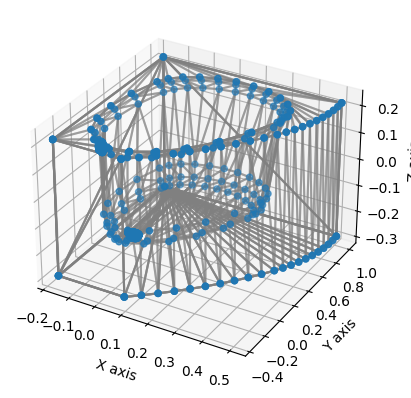

In [97]:
def visualize_graph_data(data):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Assuming 'x' contains the 3D coordinates of the nodes
    nodes = data.x.numpy()
    ax.scatter(nodes[:, 0], nodes[:, 1], nodes[:, 2])

    # Optionally, plot the edges
    for edge in data.edge_index.t().numpy():
        start, end = nodes[edge[0]], nodes[edge[1]]
        ax.plot([start[0], end[0]], [start[1], end[1]], [start[2], end[2]], color='gray', alpha=0.5)

    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    plt.show()

# Assuming 'sample' is a PyTorch Geometric Data object from your dataset
sample = train_dataset[0]
visualize_graph_data(sample)

In [98]:


class MeshGCN(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(MeshGCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, 64)
        self.conv2 = GCNConv(64, 128)
        self.fc1 = torch.nn.Linear(128, 256)
        self.fc2 = torch.nn.Linear(256, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)  # Global pooling

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


In [99]:
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        total_train_loss = 0
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, data.y)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        
        # Validation Phase
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for data in val_loader:
                data = data.to(device)
                output = model(data)
                loss = criterion(output, data.y)
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')


In [100]:
def evaluate(model, test_loader, criterion):
    model.eval()
    total_test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            outputs = model(data)
            total_test_loss += criterion(outputs, data.y).item()
            _, predicted = torch.max(outputs, 1)
            total += data.y.size(0)
            correct += (predicted == data.y).sum().item()

    avg_test_loss = total_test_loss / len(test_loader)
    accuracy = correct / total
    return avg_test_loss, accuracy


In [103]:
# Model Initialization
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MeshGCN(num_node_features=3, num_classes=10).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()


num_epochs = 15

# Train and Validate
train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs)

# Evaluate on Test Set
test_loss, test_accuracy = evaluate(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


Epoch 1/15, Train Loss: 2.0432, Val Loss: 1.7185
